## Customer Life Time Value

Digital advertising is a multibillion-dollar market, with more than $380 billion expected in 2022, with Alphabet and Meta responsible for $234 billion. This sizable digital industry is propelled by high-performance marketing tactics built through study of the advertising environment and customer Lifetime Value (LTV). Because it affects how much we are ready to pay for them, the LTV is undoubtedly the most important indicator for running a lucrative advertisement strategy. After all, we are effectively losing money if we pay more than the users are worth.  

But while the upper limit for the *Cost per User* is clear, its optimal point is not so readily determined: it depends on how many users we expect to obtain for a given *Cost per User* and how accurate the LTV estimation is. However, forecasting the LTV of marketing campaigns has challenges that are not often seen in machine learning problems:
1) LTV is zero-inflated since most users who become mobile game players or register as customers in a store never spend a single cent.
2) The distribution of the LTV of those that do purchase something is highly skewed, i.e., most of the revenue is generated by a fraction of the users.
3) The distribution of the LTV itself changes over time, requiring the prediction algorithms to adapt quickly.
4) The marketing industry is constantly changing, with some harming the accuracy of the LTV estimation, such as Apple's App Tracking Transparency (ATT).

In this context, we explain why estimating your users' LTV uncertainty matters to achieve maximum profitability and how that can be accomplished. 


# Modules

In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_history_alive


warnings.filterwarnings("ignore")

# Functions

In [2]:
# Updata functionq based on  https://github.com/lifetimes/blob/master/lifetimes/plotting.py

def plot_period_transactions(
    model,
    max_frequency=7,
    title="Frequency of transactions",
    xlabel="Number of transactions",
    ylabel="Clients",
    **kwargs
    ):
    """
    Plot a figure with period actual and predicted transactions.
    Parameters
    ----------
    model: lifetimes model
        A fitted lifetimes model.
    max_frequency: int, optional
        The maximum frequency to plot.
    title: str, optional
        Figure title
    xlabel: str, optional
        Figure xlabel
    ylabel: str, optional
        Figure ylabel
    kwargs
        Passed into the matplotlib.pyplot.plot command.
    Returns
    -------
    axes: matplotlib.AxesSubplot
    """
    from matplotlib import pyplot as plt

    labels = kwargs.pop("label", ["Actual", "Model"])

    n = model.data.shape[0]
    simulated_data = model.generate_new_data(size=n)

    model_counts = pd.DataFrame(model.data["frequency"].value_counts().sort_index().iloc[:max_frequency])
    simulated_counts = pd.DataFrame(simulated_data["frequency"].value_counts().sort_index().iloc[:max_frequency])
    combined_counts = model_counts.merge(simulated_counts, how="outer", left_index=True, right_index=True).fillna(0)
    combined_counts.columns = labels

    ax = combined_counts.plot(kind="bar", **kwargs)

    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return ax

In [3]:
def customize_corr(df: pd.DataFrame) :
    
    """ 
      Customize correlation matrix visually  
      
    Arguments:
        df - dataframe with features
    
    Returns: 
    """
    
    # modules
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(16, 10))
    
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df.corr()))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='magma')
    heatmap.set_title('Lower Correlation Matrix', fontdict={'fontsize':18}, pad=16)

# Data

In [4]:
datapath = 'Input_data/CLTV-data'

In [5]:
transaction = pd.read_pickle(f'{datapath}/sales')
transaction['tran_date'] = pd.to_datetime(transaction["tran_date"].str.replace('/','-'), format = '%d-%m-%Y')
transaction.head()

,customer_Id,DOB,Gender,city_code,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,Store_type
0,268408,02-01-1970,M,4.0,1,Clothing,1,Women,63314547725,268408,2012-04-26,1,1,806,84.630,890.630,Flagship store
1,268408,02-01-1970,M,4.0,2,Footwear,1,Mens,56844530655,268408,2012-10-14,1,5,1175,616.875,6491.875,MBR
2,268408,02-01-1970,M,4.0,2,Footwear,4,Kids,64633435931,268408,2013-05-06,4,3,312,98.280,1034.280,Flagship store
3,268408,02-01-1970,M,4.0,3,Electronics,9,Cameras,56902862040,268408,2013-01-30,9,5,868,455.700,4795.700,e-Shop
4,268408,02-01-1970,M,4.0,3,Electronics,10,Audio and video,19516063887,268408,2012-09-07,10,4,650,273.000,2873.000,e-Shop


In [6]:
rfm = pd.read_pickle(f'{datapath}/rfm.sav')
rfm = rfm[rfm.monetary_value>0]
rfm.head()

,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,266783,3.0,516.0,881.0,1037.963333,2,2,1,221,5,Hibernating,Green
1,266784,2.0,103.0,546.0,707.200000,1,2,1,121,4,Hibernating,Green
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4,444,12,Champions,Platinum
3,266788,3.0,611.0,984.0,1574.993333,2,2,2,222,6,Hibernating,Bronze
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3,443,11,Champions,Platinum


DataFrame containing the following columns:
- **frequency**: number of repeat purchases (with possible values 0, 1, 2, ...)
- **recency**: time between the first and the last purchase (with possible values 0, 1, 2, ...)
- **T`**: time between the first purchase and the end of the observation period (with possible values 0, 1, 2, ...)
- **customer_Id**: unique customer identifier

In a digital advertisement, the ultimate goal is to obtain a profit from the marketing campaign, defined as

$$ Profit \triangleq Revenue - Costs$$

, where $Revenue$ and $Cost$ can be further broken down:

$$ Profit = Users * (LTV_{user} - Cost_{user})$$

, where $Users$ stands for the number of users acquired from the marketing campaign, and $LTV_{user}$ and $Cost_{user}$ for the average LTV and Cost of those users, respectively.

But the number of users acquired from a marketing campaign depends on the digital platform, the advertised product, and how many we will put for a user. We are going to call this relationship *Volume Function* $f\left(Cost_{user}\right)$:

$$ Installs \triangleq f\left(Cost_{user}\right)$$

The resulting $Profit$ function thus becomes:

$$ Profit = f\left(Cost_{user}\right) * (LTV_{user} - Cost_{user})$$

# CLV estimation for 2 years

## Modele NBD/Pareto

In [7]:
bgf = BetaGeoFitter(penalizer_coef=0.0000005)
bgf.fit(rfm['frequency'], round(rfm['recency']/30), round(rfm['T']/30))
round(bgf.summary, 3)
# r, α, s, β

,coef,se(coef),lower 95% bound,upper 95% bound
r,68.422,7.805,53.124,83.720
alpha,624.455,71.521,484.273,764.637
a,0.461,0.238,-0.005,0.927
b,17.826,8.495,1.176,34.476


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

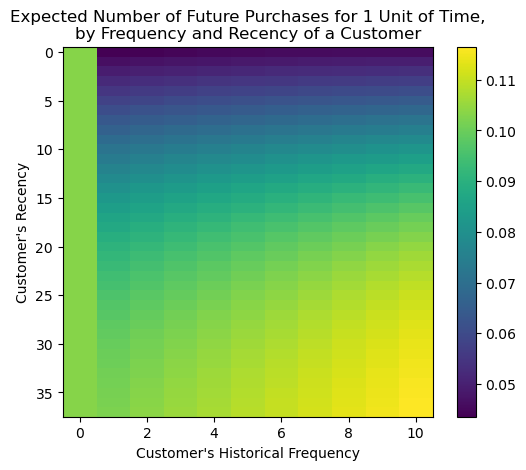

In [8]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

Our customers who are likely to make purchases are those who buy most often (in terms of number of transactions)

They seem that recency doesn't have too much of an impact on a customer's future transactions.
Our most important customers are those with the most

Customers who have purchased a lot and bought recently are likely to be the best customers in the future.
We will never have enough.
Customers who bought a lot but not recently (upper right corner) are probably gone.

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

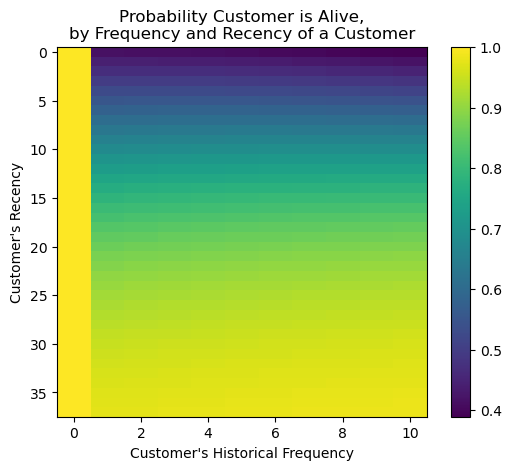

In [9]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

As a reminder, Recency represents the duration between a customer's first purchase and their last purchase.
Customers who have purchased once for a long time have a very high probability of churn.

In [10]:
t = 6
rfm['predicted_purchases'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t,rfm['frequency'], round(rfm['recency']/30), round(rfm['T']/30)),1)
rfm.sort_values(by='predicted_purchases').tail()


,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score,predicted_purchases
2133,270071,6.0,1019.0,1026.0,2951.455000,4,4,3,443,11,Champions,Platinum,0.7
773,267987,7.0,982.0,1121.0,1997.050714,4,4,2,442,10,Champions,Gold,0.7
2134,270072,5.0,944.0,958.0,1447.329000,4,4,2,442,10,Champions,Gold,0.7
2071,269967,5.0,734.0,794.0,2406.027000,3,4,3,343,10,Loyal customers,Gold,0.7
3359,271961,7.0,1053.0,1122.0,2241.729286,4,4,2,442,10,Champions,Gold,0.7


Thanks to the estimation, we can predict the number of future customer transactions. Above is for example the estimate of the number of transactions the next 6 time steps

<Axes: title={'center': 'Frequency of transactions'}, xlabel='Number of transactions', ylabel='Clients'>

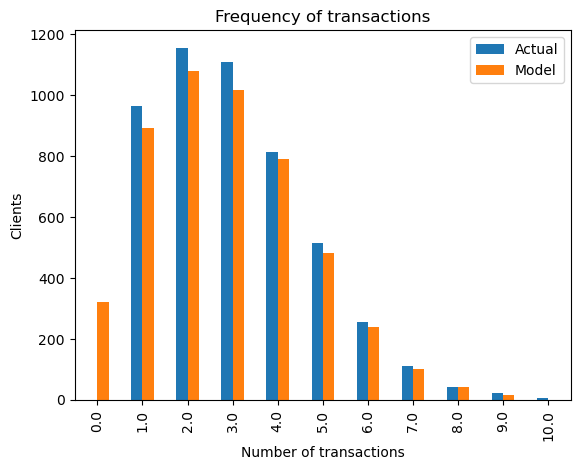

In [11]:
# Generate artificial data according to the MBG/NBD model and compare them to the real values
plot_period_transactions(bgf,max_frequency=10)

We can see that our real data and our simulated data fit very well.

In [12]:
from lifetimes.utils import calibration_and_holdout_data
sales_df = pd.read_pickle(f'{datapath}/sales')
sales_df['tran_date'] = pd.to_datetime(sales_df["tran_date"].str.replace('/','-'), format = '%d-%m-%Y')
sales_df = sales_df.sort_values(by=['customer_Id','tran_date'])

summary_cal_holdout = calibration_and_holdout_data(sales_df, 'customer_Id','tran_date',
                                        calibration_period_end='2014-01-05',
                                        observation_period_end='2014-02-20' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_Id,,,,,
266783,4.0,516.0,835.0,0.0,46.0
266784,2.0,103.0,500.0,0.0,46.0
266785,7.0,870.0,1027.0,0.0,46.0
266788,3.0,611.0,938.0,0.0,46.0
266794,9.0,835.0,1024.0,1.0,46.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

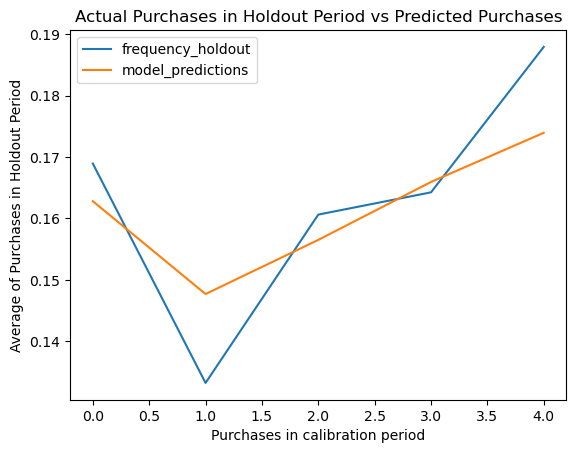

In [13]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit( summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout,n=5)

In [14]:
t = 180 # predict purchases for 6 months
temp = rfm.iloc[1999]
print(temp)
# En fait predit  = = onditional_expected_number_of_purchases_up_to_time
print('***************')
print("number of predicted transactions :", round(bgf.predict(t, temp['frequency'], temp['recency'], temp['T']/30),1))


customer_Id                 270171
frequency                      3.0
recency                      377.0
T                           1018.0
monetary_value            1914.965
R                                2
F                                2
M                                2
RFM_Segment                    222
RFM_Score                        6
Segment                Hibernating
Score                       Bronze
predicted_purchases            0.5
Name: 2198, dtype: object
***************
number of predicted transactions : 0.8


In [15]:
import matplotlib.dates as md

from lifetimes.utils import calculate_alive_path

def plot_history_alive1(model, t, transactions, datetime_col, freq="D", start_date=None, ax=None, **kwargs):
    """
    Draw a graph showing the probability of being alive for a customer in time.

    Parameters
    ----------
    model: lifetimes model
        A fitted lifetimes model.
    t: int
        the number of time units since the birth we want to draw the p_alive
    transactions: pandas DataFrame
        DataFrame containing the transactions history of the customer_id
    datetime_col: str
        The column in the transactions that denotes the datetime the purchase was made
    freq: str, optional
        Default 'D' for days. Other examples= 'W' for weekly
    start_date: datetime, optional
        Limit xaxis to start date
    ax: matplotlib.AxesSubplot, optional
        Using user axes
    kwargs
        Passed into the matplotlib.pyplot.plot command.

    Returns
    -------
    axes: matplotlib.AxesSubplot

    """
    from matplotlib import pyplot as plt

    try :

        if start_date is None:
            start_date = min(transactions[datetime_col])

        if ax is None:
            ax = plt.subplot(111)

        # Get purchasing history of user
        customer_history = transactions[[datetime_col]].copy()
        customer_history.index = pd.DatetimeIndex(customer_history[datetime_col])

        # Add transactions column
        customer_history["transactions"] = 1
        customer_history = customer_history.resample(freq).sum()

        # plot alive_path
        path = calculate_alive_path(model, transactions, datetime_col, t, freq)
        path_dates = pd.date_range(start=min(transactions[datetime_col]), periods=len(path), freq=freq)
        plt.plot(path_dates, path, "-", label="P_alive")

        # plot buying dates
        payment_dates = customer_history[customer_history["transactions"] >= 1].index
        plt.vlines(payment_dates.values, ymin=0, ymax=1, colors="r", linestyles="dashed", label="purchases")

        plt.ylim(0, 1.0)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xlim(start_date, path_dates[-1])
        plt.legend(loc=3)
        plt.ylabel("P_alive")
        plt.title("History of P_alive")

        return ax

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

An error occurred: Failed to convert value(s) to axis units: '2011-06-12'


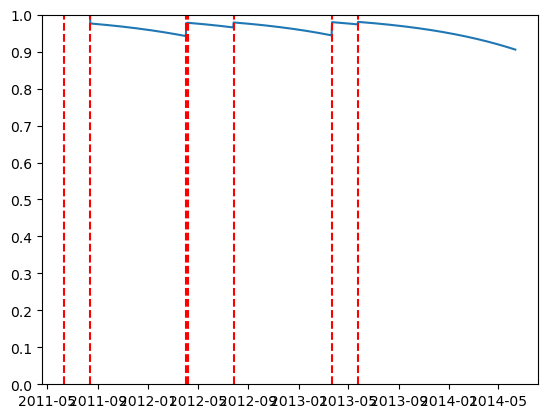

In [16]:
CUSTOMER_ID =  269864
days_since_birth = 365*3 # 3 years
cust_transaction= transaction[transaction.customer_Id == CUSTOMER_ID].reset_index(drop=True)
cust_transaction['tran_date'] = cust_transaction['tran_date'].astype(str)
#cust_transaction = cust_transaction.loc[cust_transaction['tran_date'] != '2011-06-12']
plot_history_alive1(bgf, days_since_birth, cust_transaction, 'tran_date')

This customer will definitely have a purchase in the next 6 months

## Gamma-Gamma submodel

As we have noticed, the NBD/pareto model only takes into account the monetary value of transactions. It allows us to estimate the number of transactions only.

This is why for the estimation of U CLV the gamma gamma model is used.
This model first estimates the average monetary value s taking into account transaction history and future values. As a result, one can directly estimate the CLV

Remember that Gamma Gamma has an assumption of independence between the frequency of purchases and the amount of purchases. Something we can check very easily.


In [19]:
print("************* Correlation de Pearson**********")

print(round(rfm[['frequency','monetary_value']].corr(method='pearson'),2))
print("\n*********** Correlation de Spearman****************")
print(round(rfm[['frequency','monetary_value']].corr(method='spearman'),2))

************* Correlation de Pearson**********
                frequency  monetary_value
frequency            1.00            0.02
monetary_value       0.02            1.00

*********** Correlation de Spearman****************
                frequency  monetary_value
frequency            1.00            0.11
monetary_value       0.11            1.00


In [18]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.0001)
ggf.fit(rfm['frequency'], rfm['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4993 subjects, p: 37.26, q: 1.07, v: 37.42>


In [20]:
rfm['monetary_value_pred']=ggf.conditional_expected_average_profit(rfm['frequency'],rfm['monetary_value'])


In [21]:
rfm['CLV'] = ggf.customer_lifetime_value(
                            bgf, #the model used to predict future transactions
                            rfm['frequency'],
                            rfm['recency'],
                            rfm['T'],
                            rfm['monetary_value'],
                            time=365*2, # 2 years
                             )

In [22]:
rfm

,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score,predicted_purchases,monetary_value_pred,CLV
0,266783,3.0,516.0,881.0,1037.963333,2,2,1,221,5,Hibernating,Green,0.6,1049.818664,9271.327526
1,266784,2.0,103.0,546.0,707.200000,1,2,1,121,4,Hibernating,Green,0.6,725.269356,6185.250240
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4,444,12,Champions,Platinum,0.6,3593.666993,36499.510753
3,266788,3.0,611.0,984.0,1574.993333,2,2,2,222,6,Hibernating,Bronze,0.6,1586.532957,13794.009613
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3,443,11,Champions,Platinum,0.7,2842.713571,33144.755230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,275257,3.0,637.0,808.0,4097.340000,3,2,4,324,9,Potential loyalists,Silver,0.6,4107.396798,38469.639324
5502,275261,2.0,740.0,878.0,1649.765000,3,2,2,322,7,Potential loyalists,Bronze,0.6,1667.003434,14847.737130
5503,275262,1.0,200.0,922.0,3328.260000,1,1,4,114,6,Hibernating,Bronze,0.5,3359.749741,21740.843623
5504,275264,1.0,64.0,930.0,2594.540000,1,1,3,113,5,Hibernating,Green,0.4,2627.322229,14108.798302


### Now we try with Bayesian modeling with pymc

In [23]:
import pymc as pm
from arviz.labels import MapLabeller
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from pymc_marketing import clv

In [25]:
import arviz as az

az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina" # nice looking plots

In [28]:
pyrfm = rfm[['customer_Id', 'frequency', 'recency', 'T', 'monetary_value', 'R', 'F',
       'M', 'RFM_Segment', 'RFM_Score', 'Segment', 'Score']]

In [32]:
pyrfm.rename(columns={'customer_Id': 'customer_id'}, inplace=True)

In [33]:
pyrfm

,customer_id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,266783,3.0,516.0,881.0,1037.963333,2,2,1,221,5,Hibernating,Green
1,266784,2.0,103.0,546.0,707.200000,1,2,1,121,4,Hibernating,Green
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4,444,12,Champions,Platinum
3,266788,3.0,611.0,984.0,1574.993333,2,2,2,222,6,Hibernating,Bronze
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3,443,11,Champions,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...
5501,275257,3.0,637.0,808.0,4097.340000,3,2,4,324,9,Potential loyalists,Silver
5502,275261,2.0,740.0,878.0,1649.765000,3,2,2,322,7,Potential loyalists,Bronze
5503,275262,1.0,200.0,922.0,3328.260000,1,1,4,114,6,Hibernating,Bronze
5504,275264,1.0,64.0,930.0,2594.540000,1,1,3,113,5,Hibernating,Green


#### define the priors

In [29]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
}

Here, we will replace the HalfFlat default by more well-behaved HalfNormal priors with a standard deviation of 10

In [34]:
bgm = clv.BetaGeoModel(
    data = pyrfm,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 10)
         b ~ HalfNormal(0, 10)
     alpha ~ HalfNormal(0, 10)
         r ~ HalfNormal(0, 10)
likelihood ~ Potential(f(r, alpha, b, a))

In [35]:
bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.281,0.422,1.473,3.023,0.010,0.007,1838.0,1618.0,1.0
b,34.895,5.982,23.106,45.315,0.137,0.097,1873.0,1665.0,1.0
alpha,329.917,6.280,317.566,341.311,0.140,0.099,2000.0,2158.0,1.0
r,1.657,0.030,1.598,1.712,0.001,0.000,2016.0,2169.0,1.0


We can use ArviZ, a Python library tailored to produce visualizations for Bayesian models, to plot the posterior distribution of each parameter.

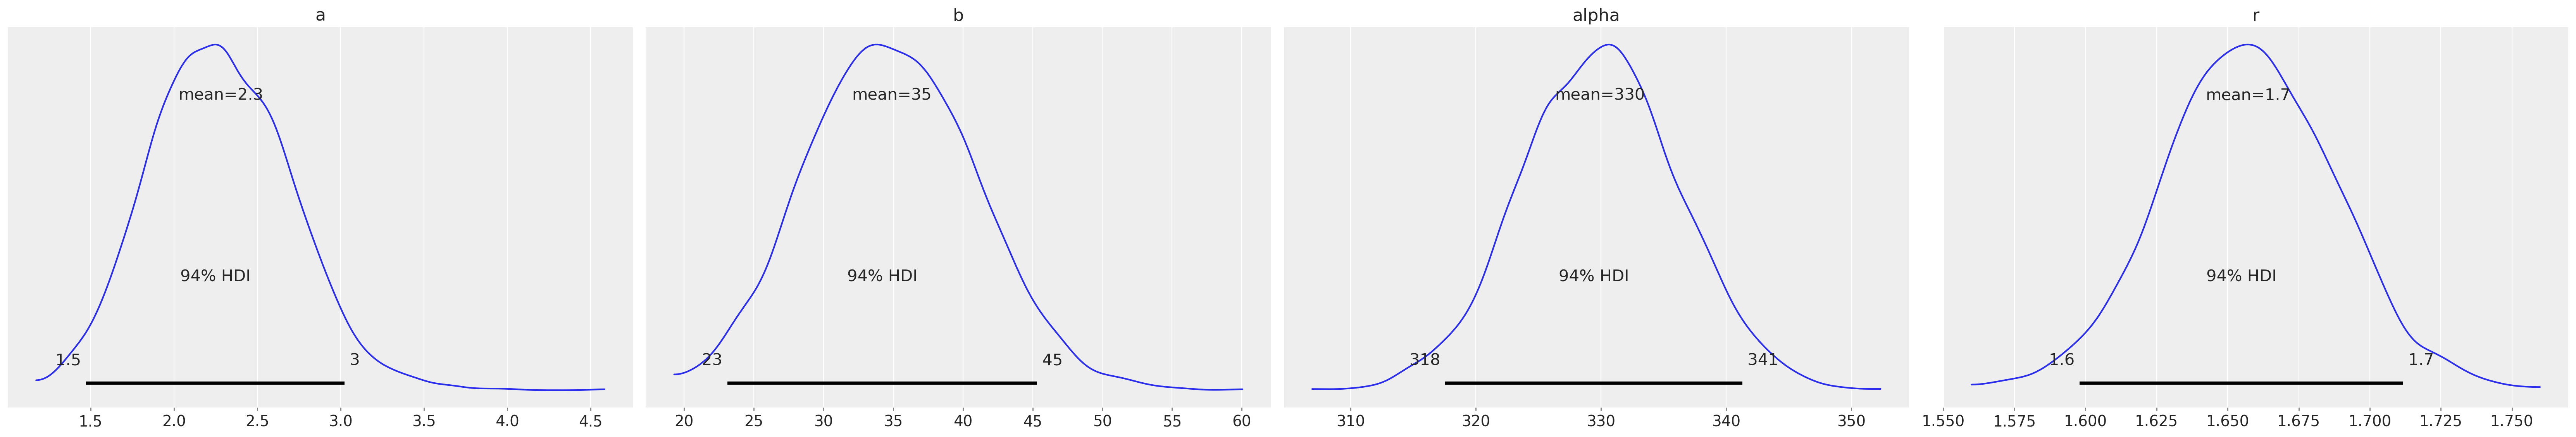

In [36]:
az.plot_posterior(bgm.fit_result);

#### Frequency/Recency correlation Matrix

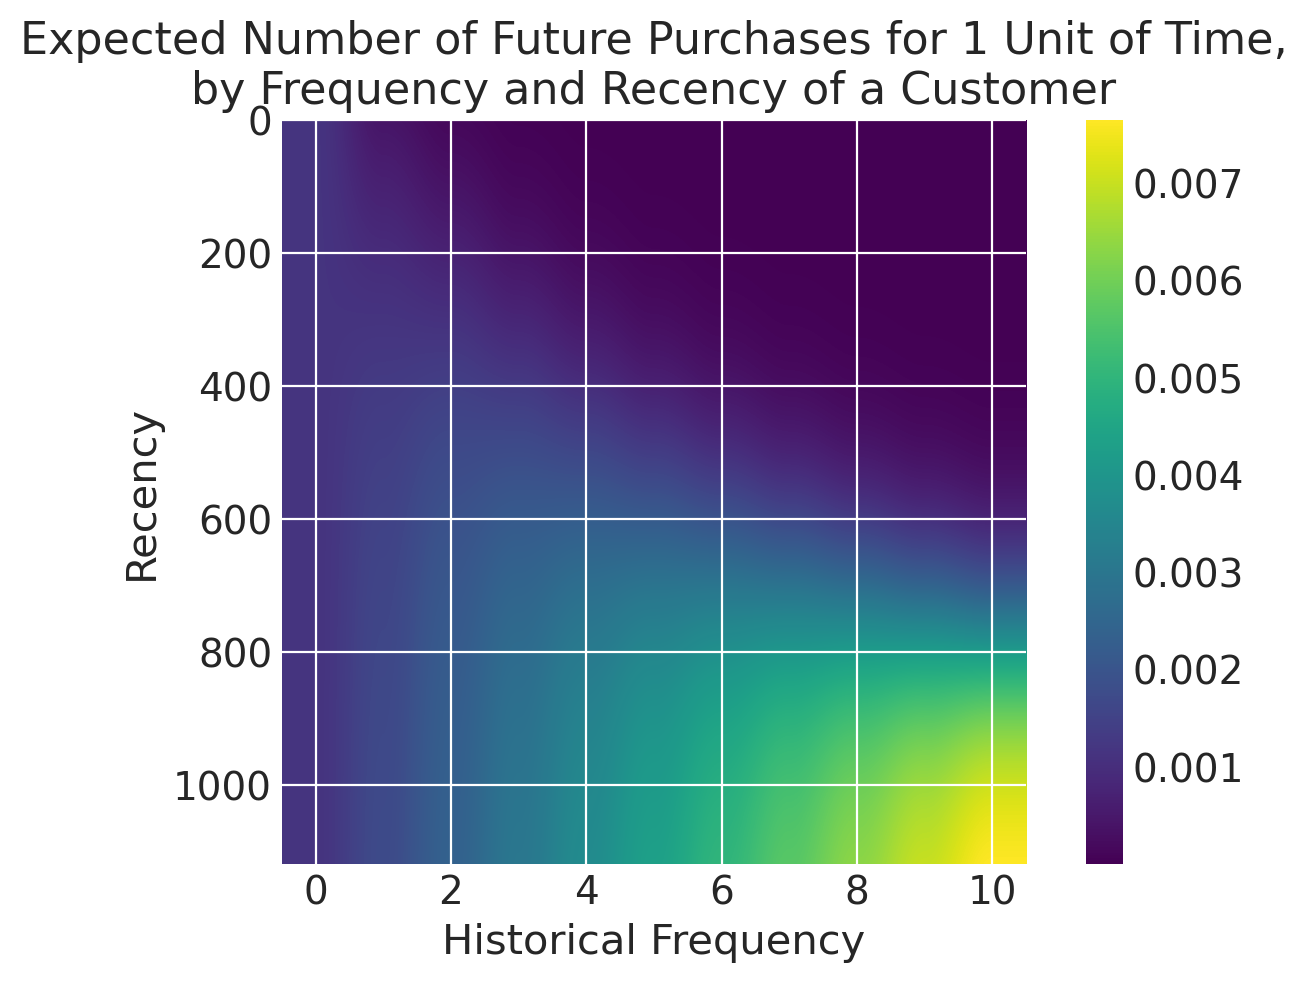

In [37]:
clv.plot_frequency_recency_matrix(bgm);

We can observe that a customer is your top customer (bottom-right). Your "coldest" customers are in the upper-right corner: they bought a lot rapidly and haven't been seen in days.

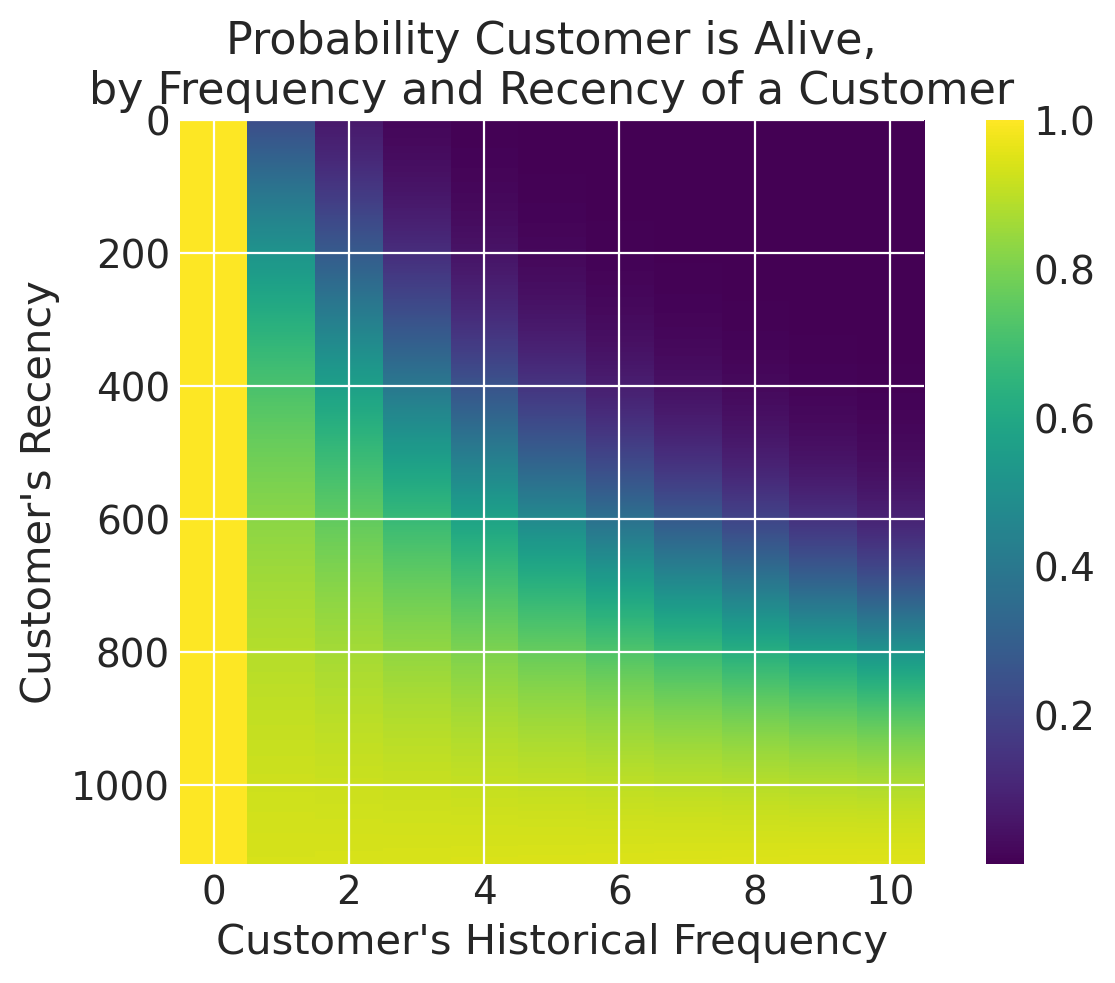

In [38]:
clv.plot_probability_alive_matrix(bgm);

Looking at the probability alive matrix, we can infer that users who have made a lot of purchases a long time ago are likely to never return.

We can use the fitted model to predict the number of purchases for a fresh new customer.

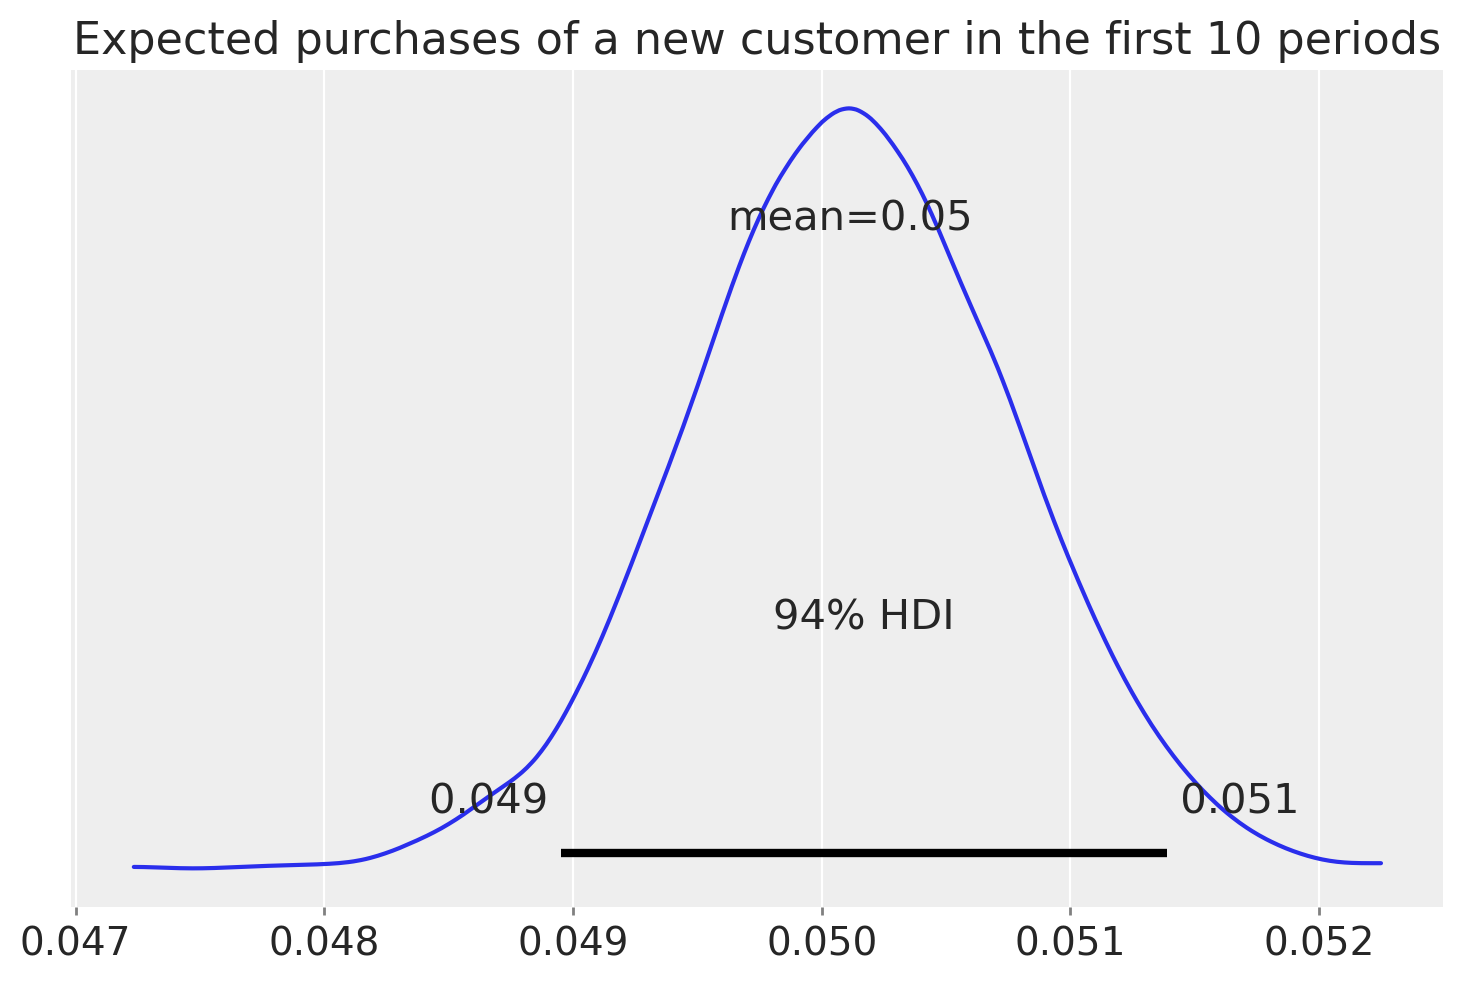

In [39]:
az.plot_posterior(
    bgm.expected_num_purchases_new_customer(t=10)
);
plt.title("Expected purchases of a new customer in the first 10 periods");

Let look at active customer 269864 and assess the change in probability that the user will ever return if they do no other purchases in the next 9 time periods.

In [43]:
CUSTOMER_ID =  269864
pyrfm_customer = pyrfm[pyrfm['customer_id'] == CUSTOMER_ID]

pyrfm_customer

,customer_id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score
1999,269864,5.0,713.0,984.0,1591.421,3,4,2,342,9,Loyal customers,Silver
